In [1]:
import sys
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

sys.path.insert(0, "..")
from src.kmeans import KMeans as KMeansMy
from src.utils import get_centroids_distortion

%load_ext autoreload
%autoreload 2
%matplotlib inline

### generate data

In [2]:
n_clusters = 10
data, y, centers = make_blobs(
    n_samples=10000, 
    n_features=32, 
    centers=n_clusters, 
    cluster_std=0.5, 
    shuffle=True,
    random_state=42,
    return_centers=True
)

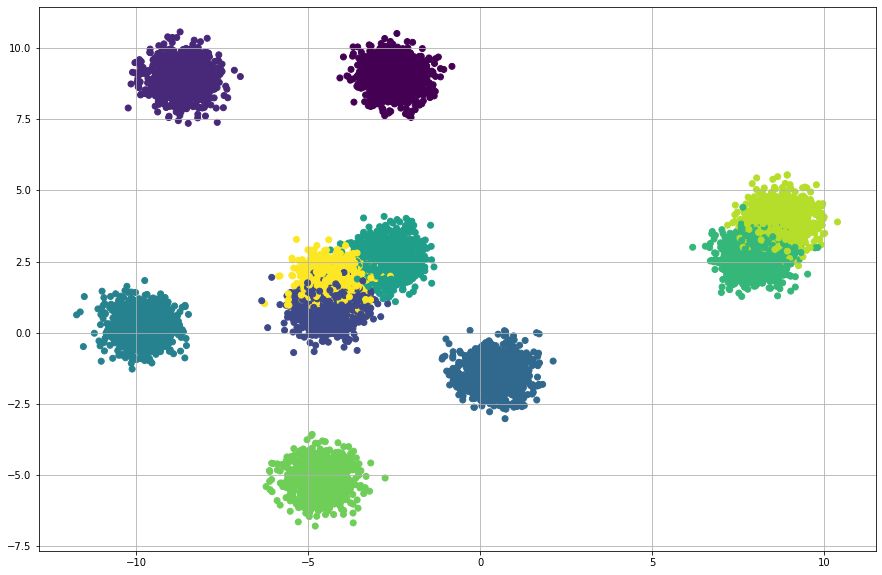

In [3]:
plt.figure(figsize=(15, 10))
plt.scatter(data[:, 0], data[:, 1], c=y)
plt.grid();

### setup

In [5]:
kwargs = {
    "n_clusters": n_clusters,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    "tol": 1e-4,
    "verbose": False,
    "algorithm": "full"  # "full" = "lloyd"
}

### test time

In [6]:
def plot_errorbar(stats):
    """
    stats[key] = mean, std
    """
    x = list(range(len(stats)))
    y = [v[0] for v in stats.values()]
    e = [v[1] for v in stats.values()]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.xticks(x, stats.keys(), rotation=90)
    plt.grid()

def test_time():
    res = {}
    for init in ["random", "k-means++"]:
        for alias, kmeans_cls in [("my", KMeansMy), ("sklearn", KMeans)]:
            print(alias, init)
            kwargs_i = kwargs.copy()
            kwargs_i["init"] = init
            kmeans = kmeans_cls(**kwargs_i)
            r = %timeit -o kmeans.fit(data)
            res[(alias, init)] = r.average, r.stdev
    plot_errorbar(res)

my random
1.18 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sklearn random
67.9 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
my k-means++
872 ms ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sklearn k-means++
979 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


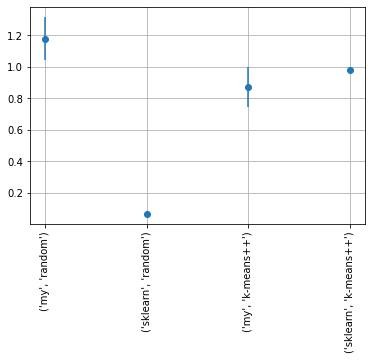

In [7]:
# TODO: разобраться, почему (sklearn, random) на порядок быстрее, чем всё остальное
test_time()

### compare centroids

In [12]:
def compare_centroids():
    kmeans_my = KMeansMy(**kwargs)

    kmeans_my.fit(data)
    centroids_kpp = kmeans_my.cluster_centers_

    kmeans_my.init = "random"
    kmeans_my.fit(data)
    centroids_random = kmeans_my.cluster_centers_

    plt.figure(figsize=(15, 8))
    plt.scatter(centers[:, 0], centers[:, 1], label="gold", marker='o', s=200, c='red', alpha=0.5)
    plt.scatter(centroids_kpp[:, 0], centroids_kpp[:, 1], label="k-means++", marker='P', s=200, c='green', alpha=0.5)
    plt.scatter(centroids_random[:, 0], centroids_random[:, 1], label="random", marker='D', s=200, c='blue', alpha=0.5)
    plt.legend()
    plt.grid();

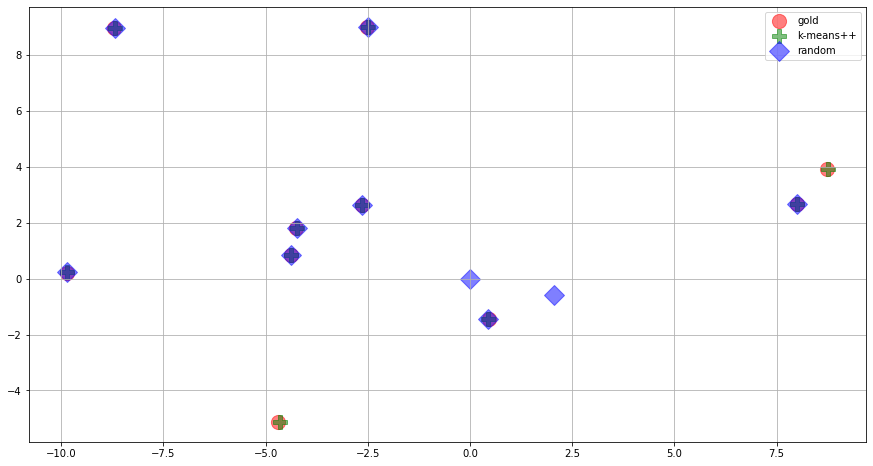

In [13]:
# видно, что random сходится не очень
compare_centroids()

### test convergence

In [10]:
import tqdm

def test_convergence(n=10):
    def test(kmeans_cls, init):
        errors = []
        for i in tqdm.trange(n):
            kwargs_i = kwargs.copy()
            kwargs_i["init"] = init
            kwargs_i["random_state"] = i
            kmeans = kmeans_cls(**kwargs_i)
            kmeans.fit(data)
            err = get_centroids_distortion(data=data, centroids=kmeans.cluster_centers_)
            errors.append(err)
        return errors
    res = {}
    for init in ["random", "k-means++"]:
        for alias, kmeans_cls in [("my", KMeansMy), ("sklearn", KMeans)]:
            print(alias, init)
            errors = test(kmeans_cls, init)
            res[(alias, init)] = np.mean(errors), np.std(errors)
    res["gold"] = get_centroids_distortion(data=data, centroids=centers), 0.0
    plot_errorbar(res)

my random


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


sklearn random


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


my k-means++


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


sklearn k-means++


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


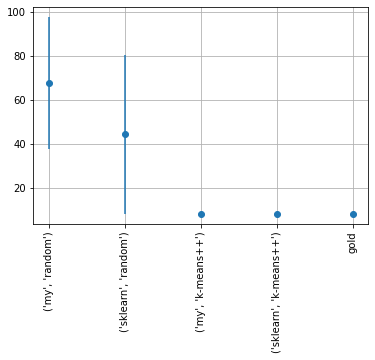

In [11]:
# random_state=42
# видно, что k-means++ сходится значительно стабильней, чем random
test_convergence()